<a href="https://colab.research.google.com/github/castaned/RNP/blob/main/rn_passwords_evaluacionparcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El presente código busca clasificar una serie de contraseñas en cuanto a su fortaleza. Las contraseñas provienen del 000webhost leak, disponible en
https://www.kaggle.com/bhavikbb/password-strength-classifier-dataset.

El dataset a utilizar presenta 670k valores distribuidos en dos columnas:

password: Contraseña a analizar.

strength: Clasíficación de fuerza de contraseña utilizando parámetros comerciales (0 es débil, 1 es medio, 2 es fuerte). 


In [1]:

import tensorflow as tf


In [2]:
#importamos las librerias necesarias
import pandas as pd
import seaborn as sns
import numpy as np

In [28]:
#importamos las funciones necesarias
from sklearn.model_selection import train_test_split             #funcion que separa los datos aleatoriamente en arreglos train/test
from sklearn.preprocessing import MinMaxScaler                   #funcion de rescalamiento de datos segun un factor dado
from sklearn.preprocessing import Normalizer                     #funcion de normalizacion
from matplotlib import pyplot as plt                             #funcion de graficacion
from keras.models import Sequential                              #modelo secuencial de keras
from keras.layers.core import Dense                              #funcion para añadir otra capa en keras
from tensorflow.keras.callbacks import EarlyStopping             #funcion que permite detener el algoritmo si no se percibe un progreso medido con ciertos parametros

In [29]:
#montamos nuestro google drive para importar archivos
#from google.colab import drive
#drive.mount('/content/drive') 

In [30]:
#importamos el dataset a utilizar de drive
df = pd.read_csv('passwords.csv', error_bad_lines=False)

b'Skipping line 2810: expected 2 fields, saw 5\nSkipping line 4641: expected 2 fields, saw 5\nSkipping line 7171: expected 2 fields, saw 5\nSkipping line 11220: expected 2 fields, saw 5\nSkipping line 13809: expected 2 fields, saw 5\nSkipping line 14132: expected 2 fields, saw 5\nSkipping line 14293: expected 2 fields, saw 5\nSkipping line 14865: expected 2 fields, saw 5\nSkipping line 17419: expected 2 fields, saw 5\nSkipping line 22801: expected 2 fields, saw 5\nSkipping line 25001: expected 2 fields, saw 5\nSkipping line 26603: expected 2 fields, saw 5\nSkipping line 26742: expected 2 fields, saw 5\nSkipping line 29702: expected 2 fields, saw 5\nSkipping line 32767: expected 2 fields, saw 5\nSkipping line 32878: expected 2 fields, saw 5\nSkipping line 35643: expected 2 fields, saw 5\nSkipping line 36550: expected 2 fields, saw 5\nSkipping line 38732: expected 2 fields, saw 5\nSkipping line 40567: expected 2 fields, saw 5\nSkipping line 40576: expected 2 fields, saw 5\nSkipping line 

b'Skipping line 525174: expected 2 fields, saw 5\nSkipping line 526251: expected 2 fields, saw 5\nSkipping line 529611: expected 2 fields, saw 5\nSkipping line 531398: expected 2 fields, saw 5\nSkipping line 534146: expected 2 fields, saw 5\nSkipping line 544954: expected 2 fields, saw 5\nSkipping line 553002: expected 2 fields, saw 5\nSkipping line 553883: expected 2 fields, saw 5\nSkipping line 553887: expected 2 fields, saw 5\nSkipping line 553915: expected 2 fields, saw 5\nSkipping line 554172: expected 2 fields, saw 5\nSkipping line 563534: expected 2 fields, saw 5\nSkipping line 565191: expected 2 fields, saw 5\nSkipping line 574108: expected 2 fields, saw 5\nSkipping line 574412: expected 2 fields, saw 5\nSkipping line 575985: expected 2 fields, saw 5\nSkipping line 580091: expected 2 fields, saw 5\nSkipping line 582682: expected 2 fields, saw 5\nSkipping line 585885: expected 2 fields, saw 5\nSkipping line 590171: expected 2 fields, saw 5\nSkipping line 591924: expected 2 field

In [31]:
df.dtypes

password    object
strength     int64
dtype: object

In [32]:
df.index

RangeIndex(start=0, stop=669640, step=1)

In [33]:
df.head()

,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1


In [34]:
#para aglizar el proceso, seleccionamos solamente los primeros 10000 valores
df = df[0:10000]

Para poder analizar esto mediante una red neuronal con un aprendizaje aceptable, se necesitan al menos 5 features que evaluar. 

A partir de la columna password, se crearan 5 parametros numericos segun las características de cada contraseña:

password_length : número de caracteres.

password_letters : número de letras en la contraseña.

password_numbers : número de números en la contraseña.

password_mayus : número de letras mayusculas en la contraseña.

password_minus : número de letras minusculas en la contraseña.

password_vowels : número de vocales en la contraseña.


In [35]:
#creamos vector de vocales
vowels = ['a','e','i','o','u']

In [36]:
#creamos arreglos que almacenen valores de caracteristicas a analizar en cada contraseña
pass_mayus = [] #num. de mayusculas
pass_minus = [] #num. de minusculas
pass_vow   = [] #num. de vocales

for i in range(len(df)):
  password = str(df['password'][i])
  pass_mayus.append(sum(1 for c in password if c.isupper()))
  pass_minus.append(sum(1 for c in password if c.islower()))
  pass_vow.append(sum(password.count(c) for c in vowels ))

In [37]:
#creamos columnas a partir de las caracteristicas de la columna password
df['password_length'] = df['password'].str.len()       
df['password_letters'] = abs(df['password'].str.len() - df['password'].str.count('\d'))             
df['password_numbers'] = df['password'].str.count('\d')    
df['password_mayus'] = pass_mayus
df['password_minus'] = pass_minus
df['password_vowels'] = pass_vow

In [39]:
df.head(20)

,password,strength,password_length,password_letters,password_numbers,password_mayus,password_minus,password_vowels
0,kzde5577,1,8,4,4,0,4,1
1,kino3434,1,8,4,4,0,4,2
2,visi7k1yr,1,9,7,2,0,7,2
3,megzy123,1,8,5,3,0,5,1
4,lamborghin1,1,11,10,1,0,10,3
5,AVYq1lDE4MgAZfNt,2,16,14,2,9,5,0
6,u6c8vhow,1,8,6,2,0,6,2
7,v1118714,1,8,1,7,0,1,0
8,universe2908,1,12,8,4,0,8,4
9,as326159,1,8,2,6,0,2,1


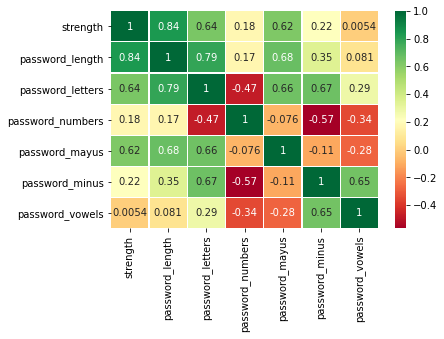

In [14]:
#se genera un grafico de correlaciones para observar la relacion entre las variables y deducir si es posible eliminar algunas sin perder informacion
fig = sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.1) #df_train.corr()-->correlation matrix

In [15]:
#eliminamos el parametros de baja correlacion
#cols = ['password_vowels']


#df = df.drop(cols, axis=1)

In [40]:
#se separan los datos en valores de entrada (features) y los valores de salida (para este caso, el diagnositco)
X_df = df                                                     #features
X_df = X_df.drop(['strength','password'], axis=1)                        #eliminamos el valor de salida de las features
y_df = df['strength']           #vector columna de diagnostico (valor de salida)

In [41]:
print(y_df.unique())
X_df.head()

[1 2 0]


,password_length,password_letters,password_numbers,password_mayus,password_minus,password_vowels
0,8,4,4,0,4,1
1,8,4,4,0,4,2
2,9,7,2,0,7,2
3,8,5,3,0,5,1
4,11,10,1,0,10,3


In [42]:
#se utiliza la funcion train_test_split para separar los datos aleatoriamente en cuatro sets: dosde entrenamiento (70%) y otros dos de prueba (30%), tanto features como valores de salida

x_tr, x_ts, y_tr, y_ts = train_test_split(X_df, y_df, test_size = 0.25, random_state = 42)   #generacion de arreglos aleatorios de features y valores de salida de entrenamiento y de prueba

y_tr = np.asarray(y_tr, dtype = np.int)   #cambiamos las variables al tipo numpy int
y_ts = np.asarray(y_ts, dtype = np.int)   

y_tr = np.reshape(y_tr, [len(y_tr),1])          #reacomodamos el arreglo según el numero de valores en el dataset
y_ts = np.reshape(y_ts, [len(y_ts),1])          

print(x_ts.shape)
print(x_tr.shape)
print(y_ts.shape)
print(y_tr.shape)

(2500, 6)
(7500, 6)
(2500, 1)
(7500, 1)


In [43]:
# procedimiento para convertir las categorias a ONE-HOT encoding   (ejemplo  3 -> (0,0,1))
from keras.utils import np_utils
n_classes = 3
y_tr = np_utils.to_categorical(y_tr,n_classes)  
y_ts = np_utils.to_categorical(y_ts,n_classes)

In [44]:
y_tr.shape
y_tr

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [45]:
# Training Data
x_tr = MinMaxScaler().fit_transform(x_tr) #reescalamos el dataframe de valores de entrenamiento como un arreglo de valores entre 0 y 1    
y_tr = MinMaxScaler().fit_transform(y_tr) #reescalamos el dataframe de valores de entrenamiento como un arreglo de valores entre 0 y 1             
print("Training Data :", x_tr.shape)

# Testing Data
x_ts = MinMaxScaler().fit_transform(x_ts) #reescalamos el dataframe de valores de prueba como un arreglo de valores entre 0 y 1   
y_ts = MinMaxScaler().fit_transform(y_ts) #reescalamos el dataframe de valores de prueba como un arreglo de valores entre 0 y 1  
print("Testing Data :", x_ts.shape)

Training Data : (7500, 6)
Testing Data : (2500, 6)


In [46]:
x_tr

array([[0.09677419, 0.16129032, 0.125     , 0.        , 0.2173913 ,
        0.22222222],
       [0.09677419, 0.16129032, 0.125     , 0.        , 0.2173913 ,
        0.55555556],
       [0.12903226, 0.16129032, 0.1875    , 0.        , 0.2173913 ,
        0.22222222],
       ...,
       [0.29032258, 0.35483871, 0.125     , 0.        , 0.47826087,
        0.55555556],
       [0.16129032, 0.22580645, 0.125     , 0.        , 0.30434783,
        0.33333333],
       [0.19354839, 0.12903226, 0.375     , 0.        , 0.17391304,
        0.22222222]])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 20)                140       
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 33        
Total params: 383
Trainable params: 383
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
59/59 [==============================] - 0s 3ms/step - loss: 0.8124 - accuracy: 0.7340 - val_loss: 0.7412 - val_accuracy: 0.7456
Epoch 2/100
59/59 [==============================] - 0s 1ms/step - loss: 0.7622 - accuracy: 0.7345 - val_loss: 0.

59/59 [==============================] - 0s 1ms/step - loss: 0.3938 - accuracy: 0.8439 - val_loss: 0.5777 - val_accuracy: 0.7508
Epoch 53/100
59/59 [==============================] - 0s 1ms/step - loss: 0.3833 - accuracy: 0.8424 - val_loss: 0.5904 - val_accuracy: 0.7500
Epoch 54/100
59/59 [==============================] - 0s 1ms/step - loss: 0.3805 - accuracy: 0.8459 - val_loss: 0.5834 - val_accuracy: 0.7512
Epoch 55/100
59/59 [==============================] - 0s 1ms/step - loss: 0.3804 - accuracy: 0.8479 - val_loss: 0.5942 - val_accuracy: 0.7508
Epoch 56/100
59/59 [==============================] - 0s 1ms/step - loss: 0.3747 - accuracy: 0.8509 - val_loss: 0.6101 - val_accuracy: 0.8080
Epoch 57/100
59/59 [==============================] - 0s 1ms/step - loss: 0.3672 - accuracy: 0.8556 - val_loss: 0.5821 - val_accuracy: 0.8096
Epoch 58/100
59/59 [==============================] - 0s 1ms/step - loss: 0.3692 - accuracy: 0.8527 - val_loss: 0.6102 - val_accuracy: 0.8180
Epoch 59/100
59/59 

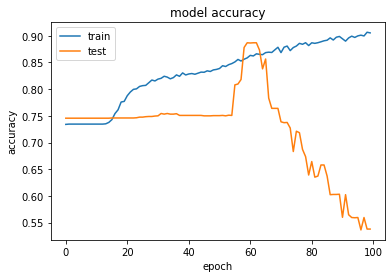

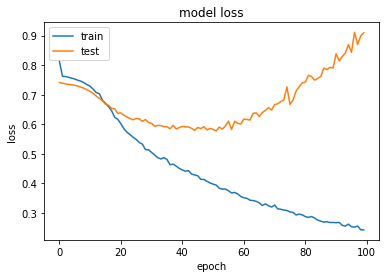

In [49]:
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import Dropout

# create a model
def create_model():
    model = tf.keras.Sequential()
    # Hidden layer
    model.add(tf.keras.layers.Dense(20, input_dim=6,activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, input_dim=10,activation='sigmoid'))

    # Output layer
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    # Compile a model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

model = create_model()
model.summary()


# training the model for 10 epochs
results = model.fit(x_tr, y_tr, batch_size=128, epochs=100, validation_data=(x_ts, y_ts))


# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

